# Scrape Indeed

### import libraries

In [1]:
from bs4 import BeautifulSoup
from selenium import webdriver 
from selenium.webdriver.chrome.options import Options
import re 
import urllib

### define scraping functions

Helper functions copied from class hw.  Make sure you copy the chrome driver into this directory!

In [2]:
#create a webdriver object and set options for headless browsing
options = Options()
options.headless = True
browser = webdriver.Chrome('./chromedriver',options=options)

#uses webdriver object to execute javascript code and get dynamically loaded webcontent
def get_js_soup(url,browser):
    browser.get(url)
    res_html = browser.execute_script('return document.body.innerHTML')
    soup = BeautifulSoup(res_html,'html.parser') #beautiful soup object to be used for parsing html content
    return soup

#tidies extracted text 
def process_bio(bio):
    bio = bio.encode('ascii',errors='ignore').decode('utf-8')       #removes non-ascii characters
    bio = re.sub('\s+',' ',bio)       #repalces repeated whitespace characters with single space
    return bio

''' More tidying
Sometimes the text extracted HTML webpage may contain javascript code and some style elements. 
This function removes script and style tags from HTML so that extracted text does not contain them.
'''
def remove_script(soup):
    for script in soup(["script", "style"]):
        script.decompose()
    return soup

#helper function to write lists to files
def write_lst(lst,file_):
    with open(file_,'w') as f:
        for l in lst:
            f.write(l)
            f.write('\n')
            
# main function that scrapes search result page            
def scrape_search_result_page(dir_url,page_result,browser):
    print ('-'*20,'Scraping indeed search result page '+ str(page_result)+'','-'*20)
    indeed_links = []
    #execute js on webpage to load faculty listings on webpage and get ready to parse the loaded HTML 
    soup = get_js_soup(dir_url,browser) 
    for link_holder in soup.find_all('div',class_='title'): #get list of all <div> of class 'photo nocaption'
        rel_link = link_holder.find('a')['href'] #get url
        #url returned is relative, so we need to add base url
        if rel_link != '':
            indeed_links.append('https://www.indeed.com' + rel_link) 
    print ('-'*20,'Found {} indeed search urls'.format(len(indeed_links)),'-'*20)
    return indeed_links

## Run scraper function

In [3]:
# build query
q = 'python developer' #job query string
l = 'New+York+State' #location of job
numPage = 20 #num pages to scrap links from
allLinks = [] # list to capture
start = 0 #pagnigation variable, page 1 = 0, page 2 = 10, page 3 = 30, etc

# loop over n number of pages
for page_result in range(numPage):
    start = page_result* 10 #increment the variable used to denote the next page
    search_result_url = 'https://www.indeed.com/jobs?q='+ q +'&l='+ l +'&start='+str(start) #build query string
    print(search_result_url)
    jobSearchResult = scrape_search_result_page(search_result_url,page_result, browser) # call scraper function
    allLinks.extend(jobSearchResult) #add to link
    

https://www.indeed.com/jobs?q=python developer&l=New+York+State&start=0
-------------------- Scraping indeed search result page 0 --------------------
-------------------- Found 18 indeed search urls --------------------
https://www.indeed.com/jobs?q=python developer&l=New+York+State&start=10
-------------------- Scraping indeed search result page 1 --------------------
-------------------- Found 19 indeed search urls --------------------
https://www.indeed.com/jobs?q=python developer&l=New+York+State&start=20
-------------------- Scraping indeed search result page 2 --------------------
-------------------- Found 19 indeed search urls --------------------
https://www.indeed.com/jobs?q=python developer&l=New+York+State&start=30
-------------------- Scraping indeed search result page 3 --------------------
-------------------- Found 17 indeed search urls --------------------
https://www.indeed.com/jobs?q=python developer&l=New+York+State&start=40
-------------------- Scraping indeed sea

### write to file for debugging

In [4]:
#Remove Duplicates
print(len(allLinks))
allLinks = list(set(allLinks))
print (len(allLinks))

369
369


In [5]:
print(allLinks)
job_urls_file = 'jobSearchResult' +q+'.txt'
# write to file
write_lst(allLinks,job_urls_file)

['https://www.indeed.com/rc/clk?jk=8a670dc8566322ff&fccid=c46d0116f6e69eae&vjs=3', 'https://www.indeed.com/rc/clk?jk=84b9fd8f448e9cfd&fccid=3d58624cd00c354b&vjs=3', 'https://www.indeed.com/rc/clk?jk=61e917c4ac7b7f11&fccid=537b899e30af3338&vjs=3', 'https://www.indeed.com/pagead/clk?mo=r&ad=-6NYlbfkN0CqDOHIPk8BI5_hSFdy52ydBlxhjoXKXlIYrz_tS6VtlpIDuNggku2YVcGU-rNavCyO8QerRwRluNaZjnTPxwhrTXr6rc5Ty9i629GqtSbV5p3GHIlugY1RVG_LoINxmKiINq6yex0k6DNPgo06u21sQAMDDv1Q62PRPFxwwgGjWdA7A6yqGQFjpXV5zd_ne20ViNOmVE37Z1AUxt9MOJbxtoBrNG9276qC7VUng4HMu4I_4TFl1qxkskxd5WHyDp0Vn3gRSFx-LcrNdAZc4EfcxdTjztc66x0S7GfmSzKj9hSBtPAZsu3-mOwP0Ig7fwBDsYrVSHgAl3cdxVL648S49j5k7iOwezXty03jvoj0JwM1XPPhGIjtaggXcLIbstf13PE2ru6VTiHY6okOnuktRXtdNE8cGYFBEz76qhZjAu-XDInV_-ZATehkMEIIivv3RD9g8VtgS9lMlT3Fkbsx_nJc_y-N9Uwf1HkZXhLcZcgWSROhgOqsdeTgVZoipXTSrI7hs3juM2hjujbPsfI3SOK7HQ2CB5NvxUghuAPe9tpxo0ks_p-SWzhXZYZMbAoMsRuECDb_1e0pe955wOx5LYNYHjDfSRIGz6qvL6GZJyL-iptubRHwhuOScw7kTX2htIL9cteE3LklpX75Hvj_K3moMA36nFRk7xilv0bhomM_YR3ByvZOtbPnLG

## Scrape page data for each link

In [6]:
from gensim.parsing.preprocessing import remove_stopwords

In [7]:
homepage_found = False
page_data = ''
page_data_list = []
for link_num, indeed_url in enumerate(allLinks):
    print("Accessing link",link_num,"of",len(allLinks))
    try:
        page_soup = remove_script(get_js_soup(indeed_url,browser)) 
    except:
        print ('Could not access {}'.format(indeed_url))
     
    page_data = process_bio(page_soup.get_text(separator=' '))  #helper function from bio hw to clean up text
    
    #remove header
    page_data = page_data[189:] #the 189 slice removes the header of the indeed pages
    
    #remove footer
    footer_position = page_data.find('save job') #find the position of 'save job' which starts the footer
    trimStringBy = footer_position - len(page_data) #returns a negative number to trim the string by
    page_data = page_data[:trimStringBy] #drop footer
    page_data = remove_stopwords(page_data)
    page_data_list.append(page_data)
    

Accessing link 0 of 369
Accessing link 1 of 369
Accessing link 2 of 369
Accessing link 3 of 369
Accessing link 4 of 369
Accessing link 5 of 369
Accessing link 6 of 369
Accessing link 7 of 369
Accessing link 8 of 369
Accessing link 9 of 369
Accessing link 10 of 369
Accessing link 11 of 369
Accessing link 12 of 369
Accessing link 13 of 369
Accessing link 14 of 369
Accessing link 15 of 369
Accessing link 16 of 369
Accessing link 17 of 369
Accessing link 18 of 369
Accessing link 19 of 369
Accessing link 20 of 369
Accessing link 21 of 369
Accessing link 22 of 369
Accessing link 23 of 369
Accessing link 24 of 369
Accessing link 25 of 369
Accessing link 26 of 369
Accessing link 27 of 369
Accessing link 28 of 369
Accessing link 29 of 369
Accessing link 30 of 369
Accessing link 31 of 369
Accessing link 32 of 369
Accessing link 33 of 369
Accessing link 34 of 369
Accessing link 35 of 369
Accessing link 36 of 369
Accessing link 37 of 369
Accessing link 38 of 369
Accessing link 39 of 369
Accessing 

## Print page data and write to file for debug

**Footer still has some text at the end which isn't properly cleaned

In [8]:
print(page_data_list[1])
document_set = page_data_list
page_data_file = 'pageText' +q+'.txt'
write_lst(page_data_list,page_data_file)

Python Developer Koneksa Health - New York, NY 10038 Koneksa Health health information technology firm. Our customers pharmaceutical biotechnology companies developing new medicines clinical trials. Koneksa's software platform integrate, manage analyze certain types 'real world' data gathered patients participate clinical studies. This includes data reported patients mobile device phone tablet, gathered types medical devices remotely collect important data activity, sleep, lung function vital signs. Responsibilities Strong 3+ years commercial coding experience - data processing pipelines / algorithms python Familiar integrating AWS, mongo APIs Experienced working following standard software development procedures Familiar enterprise architecture, data modeling modular coding patterns Work scope Building data export / processing / quality data processing pipelines: thousands rows different data sources assembling single dataset automated quality reporting data assembled2. Algorithm pipe

## Summarization Using Text Rank

### import libraries

In [9]:
from gensim.summarization import keywords
from gensim.summarization.summarizer import summarize
from gensim.summarization import mz_keywords

In [10]:
# Create single document by concatenating all documents
all_documents = ""

for doc in page_data_list:
    all_documents += doc

In [11]:
#keywords
keywords(all_documents).split('\n')


['development',
 'developer',
 'developing',
 'developments',
 'developed',
 'develops',
 'experiment',
 'working',
 'works',
 'worked',
 'data',
 'new',
 'news',
 'application',
 'applicants',
 'applicant',
 'experiences app',
 'required',
 'requires',
 'requiring',
 'excited experimenting',
 'experiments collection',
 'developers stakeholders integrate',
 'including',
 'includes',
 'include',
 'included',
 'engineer',
 'engineers',
 'engineering',
 'engine',
 'management',
 'managed',
 'manager',
 'manages',
 'manageable',
 'productivity',
 'productive',
 'software',
 'solution',
 'companys',
 'designing',
 'designers',
 'designated',
 'designs',
 'designed',
 'designer',
 'designation',
 'python',
 'businesses',
 'group work closely',
 'applications web',
 'technologies analytics',
 'supportive',
 'supporting',
 'supports',
 'supported',
 'supportable',
 'knowledge',
 'knowledgeable',
 'develop approaches understanding individual client',
 'information technology',
 'deliver continu

In [12]:
print(summarize(all_documents, word_count  = 250))

- New York, NY $45 - $55 hour Job Details: 4 years experience Excellent problem-solving skills technical vision Good organizational leadership skills Ability communicate complex technical problems abstract terms Mastery technologies use team especially React, API, Databases, Python In depth experience building large-scale, high-availability SaaS solutions cloud Experience delivering applications microservice architectures experience delivering applications microservice architectures Hands ability code troubleshoot problems direct team resolving issues Development Skills: Writing reusable, testable, efficient code Design implementation low-latency, high-availability applications Integration user-facing elements developed front-end developers server logic Implementation security data protection Integration data storage solutions (may include databases, key-value stores, blob stores, etc.) Good understanding server-side templating languages Basic understanding front-end technologies viz J

In [13]:
print(mz_keywords(all_documents,scores=True,threshold=0.001))

/Users/brianyoo/anaconda3/lib/python3.6/site-packages/gensim/summarization/mz_entropy.py:65: RuntimeWarning: divide by zero encountered in log2
  log_p = np.log2(p)
/Users/brianyoo/anaconda3/lib/python3.6/site-packages/gensim/summarization/mz_entropy.py:66: RuntimeWarning: invalid value encountered in multiply
  h = np.nan_to_num(p * log_p).sum(axis=0)


[('qlikview', 0.005088510295215713), ('cornell', 0.004516921539896983), ('we', 0.0033971973064203273), ('data', 0.00304374522259), ('google', 0.0028779701621128658), ('university', 0.0027972238954473276), ('arxiv', 0.002580160727872564), ('trading', 0.002169114473719302), ('ibm', 0.0021277889741691267), ('seen', 0.002070278025045001), ('companies', 0.002054970548138332), ('triplebyte', 0.001836853724920864), ('you', 0.0016341737351540802), ('experience', 0.0015408764275659042), ('business', 0.0014633397654268709), ('blinddata', 0.0014291637305653214), ('talent', 0.0014082021238471269), ('hadoop', 0.001317497567105265), ('get', 0.0012349967701317148), ('engineering', 0.0012338667898803988), ('solutions', 0.0012337434474747656), ('legacy', 0.0012201249505127023), ('backend', 0.0011862364625602243), ('motesque', 0.0011827505244981656), ('development', 0.0011497389268994387), ('plus', 0.0011235409751716703), ('software', 0.001121229248024819), ('build', 0.001108016070639037), ('hrt', 0.001

# Topic Modeling

### import libraries

In [14]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import LsiModel
from gensim.models import HdpModel
from gensim.models.wrappers import LdaMallet
from pprint import pprint


### tokenize the documents

In [15]:
docs = page_data_list

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are less than 3 characters.
docs = [[token for token in doc if len(token) > 3] for doc in docs]

must download wordnet!!!

In [16]:
 # nltk.download('wordnet')

### lemmatize the documents

In [17]:
lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

### compute bigrams

In [18]:
# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=10)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

### remove rare and common tokens

In [19]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.75)

In [20]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [21]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 1416
Number of documents: 369


## Build LDA Model

In [66]:
# Set training parameters.
num_topics = 20
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [172]:
num_top_words = 10
top_topics = lda_model.top_topics(corpus, topn=num_top_words) #, num_words=10)
# print(top_topics)
# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)


for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Average topic coherence: -0.9900.
Topic: 0 
Words: 0.031*"student" + 0.024*"project" + 0.019*"data" + 0.014*"support" + 0.014*"learning" + 0.012*"analytics" + 0.012*"skill" + 0.012*"provide" + 0.012*"education" + 0.012*"feedback"
Topic: 1 
Words: 0.023*"company" + 0.010*"engineer" + 0.010*"process" + 0.010*"best" + 0.010*"talent" + 0.010*"software" + 0.010*"building" + 0.010*"triplebyte" + 0.009*"data" + 0.009*"engineering"
Topic: 2 
Words: 0.018*"development" + 0.014*"technology" + 0.014*"solution" + 0.013*"data" + 0.012*"skill" + 0.011*"business" + 0.011*"knowledge" + 0.010*"review" + 0.009*"software" + 0.009*"design"
Topic: 3 
Words: 0.150*"data" + 0.035*"insight" + 0.027*"business" + 0.017*"this" + 0.017*"reporting" + 0.014*"time" + 0.013*"analytical" + 0.013*"product" + 0.012*"scientist" + 0.011*"role"
Topic: 4 
Words: 0.033*"software" + 0.025*"data" + 0.023*"engineer" + 0.013*"software_engineer" + 0.013*"engineering" + 0.009*"technology" + 0.008*"research" + 0.008*"learning" + 0.

In [173]:
print(lda_model)

LdaModel(num_terms=1416, num_topics=20, decay=0.5, chunksize=2000)


### convert to DataFrame

In [174]:
import pandas as pd
import seaborn as sns
import numpy as np

def create_df_from_top_topics(top_topics):
    ''' function that coverts lda_model.top_topics() data into pandas dataframe
    '''
    # initialize empty lists
    p_word_topic = []
    word = []
    coherence = []
    topic_number_idx = []
    
    # loop through topics
    for t, topic in enumerate(top_topics):
        
        # obtain probability and word vectors
        p_vec,w_vec = zip(*topic[0])
        for p,w in zip(p_vec,w_vec):
            p_word_topic.append(p)
            word.append(w)
            coherence.append(topic[1])
            topic_number_idx.append(t)
    
    # covert lists to dict
    dict = {'p_word_topic': p_word_topic,
            'word': word,
            'coherence': coherence,
            'topic_number_idx': topic_number_idx,
           }
    
    return pd.DataFrame(dict)
        
df = create_df_from_top_topics(top_topics)

### Visualize dataframes

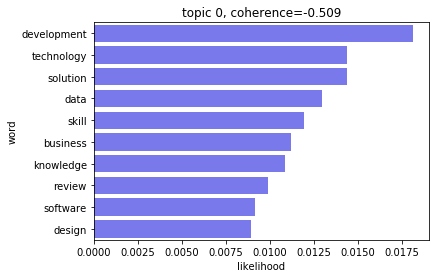

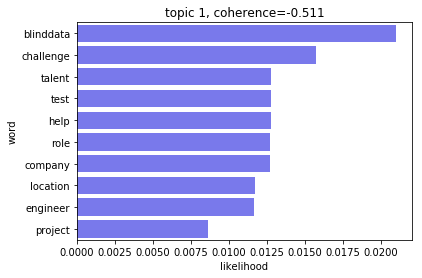

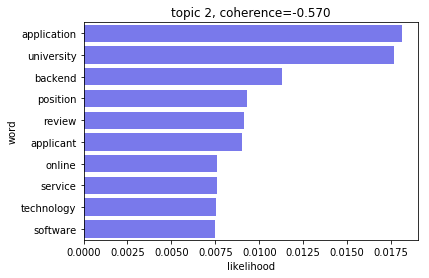

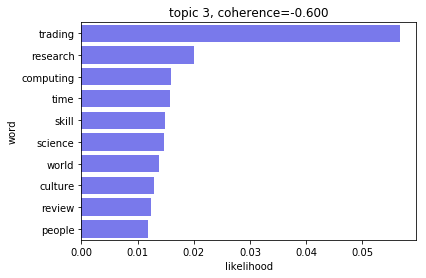

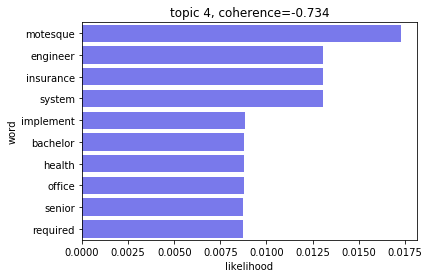

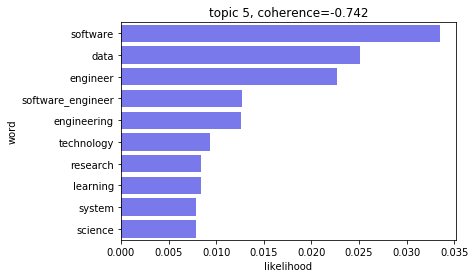

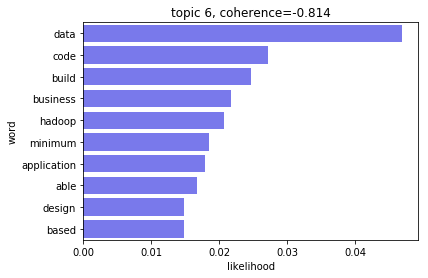

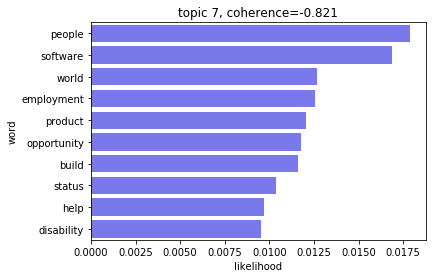

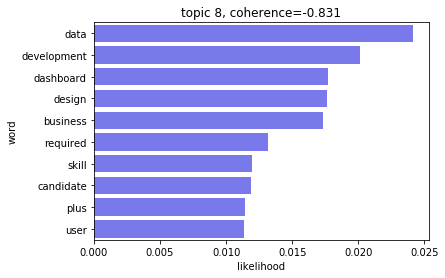

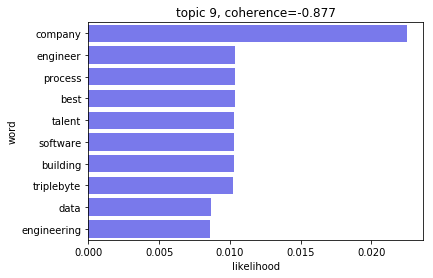

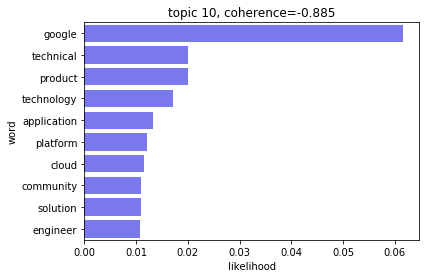

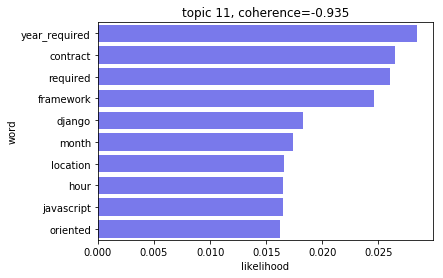

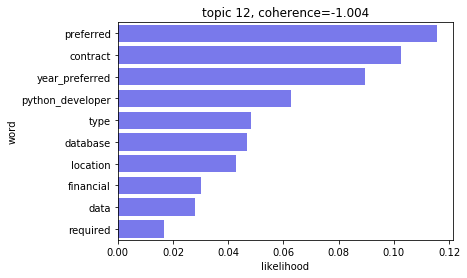

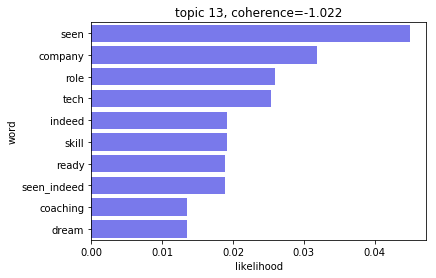

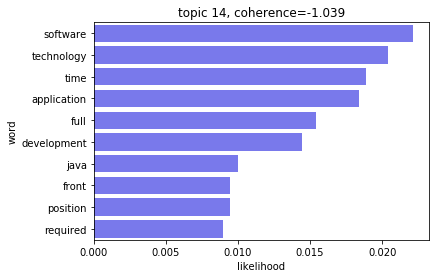

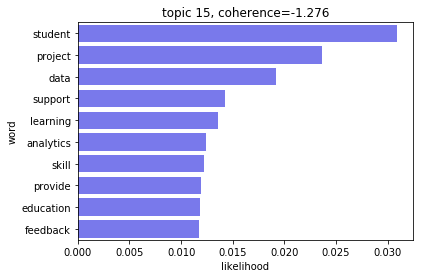

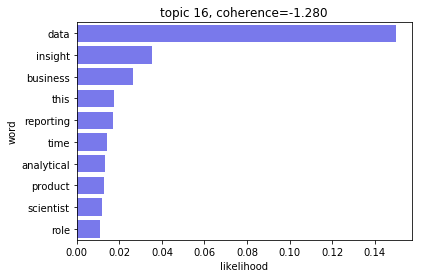

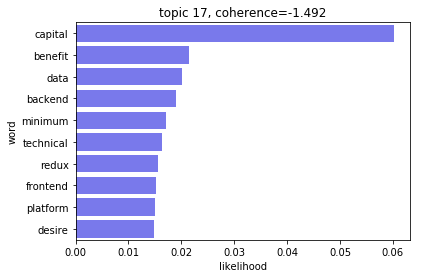

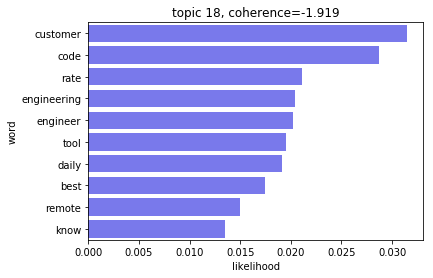

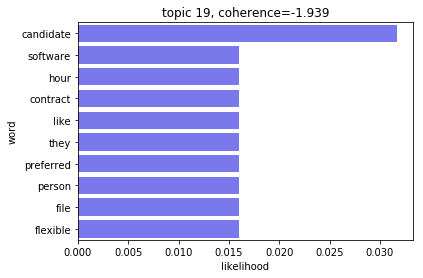

In [178]:
for n in df.topic_number_idx.unique():
    df_sparse = df[df['topic_number_idx']==n]
    
    plt.title('topic '+str(n)+', coherence='+str('%4.3f'%df_sparse.coherence.mean()))
    sns.barplot(x='p_word_topic',y='word',data=df_sparse,color='b',alpha = 0.6)
#     print(df_sparse)
    plt.xlabel('likelihood')
#     plt.xlim([0, max(df.p_word_topic)])
    plt.show()
    

### PCA

(122, 100)


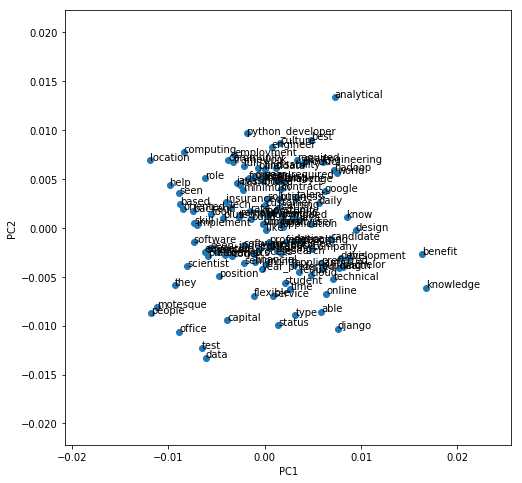

In [225]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA

# print(top_topics)

# create setences from each topic

# TODO: might need to re-weigh the sentence based on their probabilities
topic_sentence = []
for topic in top_topics:
    p_vec,w_vec = zip(*topic[0])
    topic_sentence.append(w_vec)
    
# train model by creating word2vec neural network
model = Word2Vec(topic_sentence, min_count=1)

# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
print(np.shape(X))

# only look at the first two components
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# create a scatter plot of the projection
plt.figure(figsize=(8,8))

pca1 = result[:, 0]
pca2 = result[:, 1]


plt.scatter(pca1, pca2)
words = list(model.wv.vocab)

for i, word in enumerate(words):
#     print(word)
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


# TODO: need to group each word with topics, then plot centroid + 95% CI. 
# Should look something similar pyldavis plot

### Visualize using pyLDAvis

Here we will visualize the topic models using pyLDAvis.
ref: http://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

Example Notebook: https://markroxor.github.io/gensim/static/notebooks/gensim_news_classification.html#topic=0&lambda=1&term=

In [28]:
# make sure to pip install pyldavis to run visualization

In [29]:
import pyLDAvis.gensim
import warnings
warnings.filterwarnings('ignore')

In [30]:
pyLDAvis.enable_notebook()

In [83]:
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.140058  0.073569       1        1  17.865911
1     -0.122856 -0.203316       2        1  14.347872
18     0.056478  0.081680       3        1  14.032865
15     0.057202  0.023140       4        1   8.319613
8     -0.132527 -0.214981       5        1   5.771146
16     0.119298 -0.046249       6        1   5.602745
19    -0.079542 -0.164959       7        1   5.601213
17     0.127445  0.087917       8        1   4.809646
14     0.040783 -0.012381       9        1   4.341496
7     -0.231986  0.022644      10        1   3.817844
4      0.114132 -0.041328      11        1   3.770898
11    -0.282505  0.238365      12        1   3.346521
5      0.159331  0.002221      13        1   2.756061
6      0.125745  0.007658      14        1   2.400599
0      0.108981  0.050552      15        1   1.384202
3      0.023208  0.019712      16        1   0.756023
10     0.014061  0.029118      17        1   0.454816
9     -0.150241  0.123161      18        1   0.299789
12    -0.015638 -0.096054      19        1   0.244915
13    -0.071427  0.019532      20        1   0.075819, topic_info=     Category        Freq              Term       Total  loglift  logprob
term                                                                     
28    Default  912.000000              data  912.000000  30.0000  30.0000
292   Default  275.000000         preferred  275.000000  29.0000  29.0000
129   Default  710.000000          software  710.000000  28.0000  28.0000
644   Default  179.000000          contract  179.000000  27.0000  27.0000
543   Default  297.000000         candidate  297.000000  26.0000  26.0000
594   Default  303.000000          location  303.000000  25.0000  25.0000
12    Default  451.000000          business  451.000000  24.0000  24.0000
344   Default  342.000000              code  342.000000  23.0000  23.0000
185   Default  165.000000  python_developer  165.000000  22.0000  22.0000
36    Default  589.000000       development  589.000000  21.0000  21.0000
141   Default  540.000000        technology  540.000000  20.0000  20.0000
128   Default  440.000000             skill  440.000000  19.0000  19.0000
260   Default  425.000000          engineer  425.000000  18.0000  18.0000
192   Default  198.000000              type  198.000000  17.0000  17.0000
474   Default  373.000000          required  373.000000  16.0000  16.0000
871   Default  181.000000          database  181.000000  15.0000  15.0000
312   Default  245.000000              tool  245.000000  14.0000  14.0000
51    Default  167.000000         financial  167.000000  13.0000  13.0000
736   Default  335.000000       engineering  335.000000  12.0000  12.0000
577   Default  165.000000            google  165.000000  11.0000  11.0000
333   Default  234.000000           backend  234.000000  10.0000  10.0000
306   Default  378.000000            system  378.000000   9.0000   9.0000
182   Default  307.000000          platform  307.000000   8.0000   8.0000
20    Default  672.000000           company  672.000000   7.0000   7.0000
118   Default  524.000000            review  524.000000   6.0000   6.0000
313   Default  140.000000           trading  140.000000   5.0000   5.0000
198   Default  292.000000              best  292.000000   4.0000   4.0000
9     Default  338.000000             build  338.000000   3.0000   3.0000
222   Default  200.000000              like  200.000000   2.0000   2.0000
711   Default  140.000000              seen  140.000000   1.0000   1.0000
...       ...         ...               ...         ...      ...      ...
402   Topic20    0.988364              hour   97.977379   2.5881  -4.1331
652   Topic20    0.506155             mysql   51.112186   2.5696  -4.8023
646   Topic20    0.506214            future   59.251278   2.4220  -4.8022
494   Topic20    0.506155              site   61.020885   2.3924  -4.8023
315   Topic20    0.506197      

## Build LSI Model

In [24]:
# Build the LSI Model
lsi_model = LsiModel(corpus=corpus, id2word=id2word, num_topics=10, decay=0.5)

In [25]:
pprint(lsi_model.print_topics(-1))

[(0,
  '0.292*"data" + 0.211*"company" + 0.189*"software" + 0.187*"application" + '
  '0.165*"development" + 0.141*"business" + 0.138*"technology" + '
  '0.136*"design" + 0.129*"technical" + 0.128*"review"'),
 (1,
  '-0.327*"company" + -0.169*"talent" + -0.162*"triplebyte" + '
  '0.149*"application" + -0.146*"engineer" + -0.132*"best" + 0.129*"business" '
  '+ -0.121*"great" + 0.120*"design" + -0.116*"building"'),
 (2,
  '-0.320*"university" + 0.313*"data" + 0.195*"business" + '
  '-0.155*"application" + 0.143*"development" + -0.137*"backend" + '
  '-0.133*"online" + -0.128*"position" + -0.127*"legacy" + -0.126*"applicant"'),
 (3,
  '0.305*"data" + -0.227*"software" + -0.180*"google" + -0.167*"technology" + '
  '0.150*"university" + -0.145*"role" + 0.138*"dashboard" + '
  '-0.138*"opportunity" + -0.120*"product" + -0.118*"solution"'),
 (4,
  '-0.271*"data" + -0.222*"build" + 0.187*"dashboard" + 0.169*"required" + '
  '-0.164*"hadoop" + 0.155*"development" + 0.137*"user" + 0.137*"locati

## Build HDP Model

HDP model determines number of topics automatically

In [63]:
hdp_model = HdpModel(corpus=corpus, id2word=dictionary)

In [64]:
pprint(hdp_model.show_topics())

[(0,
  '0.010*data + 0.008*software + 0.008*development + 0.006*skill + '
  '0.005*design + 0.005*required + 0.005*business + 0.005*solution + '
  '0.005*review + 0.005*technology + 0.005*framework + 0.004*build + '
  '0.004*management + 0.004*client + 0.004*javascript + 0.004*requirement + '
  '0.004*strong + 0.004*application + 0.004*ability + 0.004*people'),
 (1,
  '0.017*data + 0.008*business + 0.008*application + 0.008*build + '
  '0.008*technology + 0.008*code + 0.006*design + 0.006*knowledge + '
  '0.006*solution + 0.005*preferred + 0.005*review + 0.005*engineer + '
  '0.005*hadoop + 0.005*skill + 0.005*develop + 0.005*google + 0.004*software '
  '+ 0.004*based + 0.004*able + 0.004*minimum'),
 (2,
  '0.013*company + 0.007*talent + 0.006*best + 0.006*engineering + '
  '0.006*building + 0.006*process + 0.006*triplebyte + 0.006*engineer + '
  '0.006*software + 0.005*great + 0.005*data + 0.005*time + 0.004*insurance + '
  '0.004*technical + 0.004*full + 0.004*problem + 0.004*full_st